In [2]:
import os
os.environ["config"] = "/home/msun415/induction/src/config/bn.yaml"
import sys
os.chdir('/home/msun415/induction/')
import pickle
from src.config import METHOD, DATASET, GRAMMAR
import importlib
from src.examples import *
from src.draw.color import to_hex, CMAP
from src.draw.graph import draw_graph
from src.config import RADIUS
from argparse import ArgumentParser
import pickle
from src.grammar.common import get_args
from src.grammar.ednce import *
from src.draw.graph import *
from src.api.get_motifs import *
from src.algo.utils import *
from src.algo.common import *
from src.grammar.common import *
from src.grammar.utils import *
from src.algo.ednce import terminate, dfs
from argparse import ArgumentParser
from networkx.algorithms.isomorphism import DiGraphMatcher
import pdb
from datetime import datetime

/home/msun415/miniconda3/envs/ckt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: '/home/msun415/induction/data/api_bn_ednce.log'

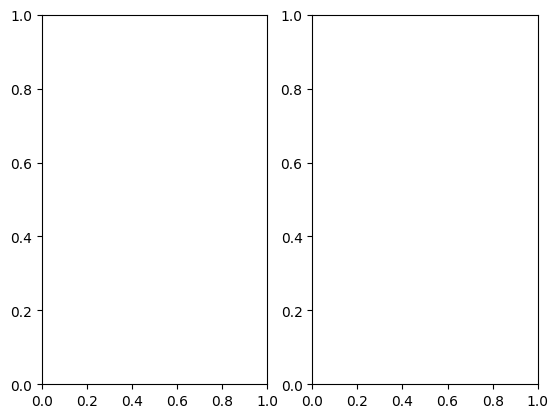

In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
%matplotlib inline

def match(timestamp):
    pattern = r"(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})"
    match = re.match(pattern, timestamp)
    if match:
        year, month, day, hour, minute, second = map(int, match.groups())
        dt = datetime(year, month, day, hour, minute, second)
    else:
        print("No match found!")    
        return None
    return dt


def get_times(last_run, fpath):
    lines = open(fpath).readlines()
    # match string of the form: [2024-12-27 05:31:10,487][       ednce.py][line: 547][    INFO] graph at iter 1 has 49144 nodes
    pattern = r'(\[\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}\]\[\s*\w+\.py\]\[line: \d+\]\[.*\] graph at iter (\d+) has (\d+)) nodes'
    occurs = [re.match(pattern, line) for line in lines]
    occurs = list(filter(None, occurs))
    start_inds = [i for i in range(len(occurs)) if occurs[i].groups()[1] == '1']
    index_start = start_inds[-last_run]
    index_end = start_inds[-(last_run-1)] if last_run > 1 else len(occurs)
    dts = []
    print(index_start, index_end)
    for i in range(index_start, index_end):
        i1 = occurs[i].groups()[0].index('[')
        i2 = occurs[i].groups()[0].index(']')
        dt_cur = match(occurs[i][0][i1+1:i2])
        if i > index_start:
            dt_diff = (dt_cur-dt)
            dts.append(dt_diff.seconds)
        dt = dt_cur
    return dts


def get_sizes(last_run, fpath):
    lines = open(fpath).readlines()
    # match string of the form: [2024-12-27 05:31:10,487][       ednce.py][line: 547][    INFO] graph at iter 1 has 49144 nodes
    pattern = r'(\[\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}\]\[\s*\w+\.py\]\[line: \d+\]\[.*\] graph at iter (\d+) has (\d+)) nodes'
    occurs = [re.match(pattern, line) for line in lines]
    occurs = list(filter(None, occurs))
    start_inds = [i for i in range(len(occurs)) if occurs[i].groups()[1] == '1']
    index_start = start_inds[-last_run]
    index_end = start_inds[-(last_run-1)] if last_run > 1 else len(occurs)
    inds = []
    vals = []
    print(index_start, index_end)
    for i in range(index_start, index_end):
        i1 = occurs[i].groups()[0].index('[')
        i2 = occurs[i].groups()[0].index(']')
        inds.append(int(occurs[i].groups()[1]))
        vals.append(int(occurs[i].groups()[2]))
    # account for restarts, cases where a later ind "pops" all prev. elements >= ind
    new_inds = []
    new_vals = []
    for ind, val in zip(inds, vals):
        while len(new_inds) and ind <= new_inds[-1]:
            new_inds.pop(-1)
            new_vals.pop(-1)
        new_inds.append(ind)
        new_vals.append(val)
    inds = new_inds
    vals = new_vals 
    return inds, vals   


def plot_run(last_run, ax, plot_time=False, **kwargs):    
    lines = []
    for d, c, s, n in zip(['ckt_f12', 'enas', 'bn'], ['r','g','b'], [47877,152160,2000000], [5000,19020,200000]):
        if plot_time:
            dts = get_times(last_run, f'/home/msun415/induction/data/api_{d}_ednce.log')
            ax.plot(range(len(dts)), dts, color=c, **kwargs)
            ax.set_ylim([0, 1500])
            ax.set_xlim([len(dts)-10, len(dts)])
        else:
            inds, vals = get_sizes(last_run, f'/home/msun415/induction/data/api_{d}_ednce.log')
            if d == 'ckt_f12':
                inds.pop(-1)
                vals.pop(-1)
            # if d == 'enas':
            #     inds.append(len(inds)+1)
            #     vals.append(19020)
            # elif d == 'bn':
            #     inds.append(len(inds)+1)
            #     vals.append(200000)     
            no_iters = max(inds)    
            t = vals[-1]   
            vals = np.array(vals)/s
            inds = np.array(inds)/no_iters
            if d == 'ckt_f12':
                d = 'ckt'            
            line, = ax.plot(inds, vals, color=c, label=f"{d}: {s}->{t}->{n}", **kwargs)
            lines.append(line)
            no_str = ' '*(4-len(str(no_iters))) + str(no_iters)
            ax.annotate(
                f"Iter {no_str}",  # The text to display
                (inds[-1], vals[-1]),        # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(-50, -12),            # Offset position (x, y)
                # arrowprops=dict(arrowstyle="->", color="gray"),  # Optional arrow
                fontsize=10                 # Font size of the text
            )                        
            ax.set_ylabel("Size (|V|) Ratio to Original Graph")
            ax.set_xlabel("Iteration # / Total Iterations")
            ax.set_xlim([0, 1])
            ax.set_ylim([0.2, 1.05])
            # ax.axhline(1.0, label=f"Initial size: {s}", color=c, linestyle='solid')
            # ax.axhline(n/s, label=f"{s}->{t}->{n}", color=c) # final size    
                
    legend1 = ax.legend(handles=lines, loc='lower left')
    bar = ax.axhline(1.0, xmin=0, xmax=0.1, linestyle='dashed', label=f"|D| (ckt, enas, bn): (5000, 19020, 200000)", color='black') # final size
    legend2 = ax.legend(handles=[bar], loc='upper right')
    # ax.add_artist(legend1)
    ax.add_artist(legend1)
    ax.set_title("Initial, Terminate and Final |V| for each Dataset")
plt.close('all')
fig, axes = plt.subplots(1,1)
plot_run(1, axes)
# plot_run(1, axes[1], plot_time=True, c='red')
fig.show()

In [ ]:
axes.axhline(1.0, label=f"|D| (ckt, enas, bn): (5000, 19020, 200000)") # final size
axes.legend()
fig